# IEEE SPS Seasonal School on Networked Federated Learning 
# https://ieeespcasfinland.github.io/
# Exericse 3

Networked federated learning uses datasets with an intrinsic network structure. We can conveniently represent networked collections of local datasets by an undirected weighted graph, which we refer to as an empirical graph. The nodes of an empirical graph are numbered by a natural number $i=0,1,\ldots$. 
Each node $i=0,1,\ldots$ of an empirical graph represents a local dataset which consists of several individual data points. 

Different local datasets are related by some notion of similarity that is represented by a set $\mathcal{E}$ of undirected edges. For two similar data sets, connected by an edge $\{i,j\}$, we quantify their similarity by a positive edge weight $A_{ij}>0$. The neighborhood $\mathcal{N}(i)$ of a node $i$ is the set of all other nodes $j$ that are connected with node $i$ by and edge $\{i,j\}$. The degree $d_{i}:=|\mathcal{N}(i)|$ of a node $i$ is the number of its neighbours.  

To summarize, an empirical graph is an object that represents a collection of local datasets along with their similarities. We will use an empirical grpah not only to represent networked data but also the corresponding networked models. In particular, each node in an empirical graph will be assigned a model parameter that can be tuned based on training data. 

The Python package `networkx` provides convenient means for storing and manipulating networked data and models. We will demonstrate how to generate and process an empirical graph using the class `networkx.Graph` and its methods. 

The code snippet below generates a `networkx.graph` object that represents networked data.

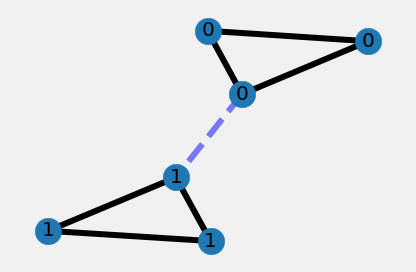

In [55]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

G.add_nodes_from(range(6))  # add six nodes i=0,..,5 to the graph G. 

# assign nodes i=0,1,2 to block 0 

G.node[0]["block"] = 0 
G.node[1]["block"] = 0 
G.node[2]["block"] = 0 

# assign nodes i=3,4,5 to block 1

G.node[3]["block"] = 1
G.node[4]["block"] = 1 
G.node[5]["block"] = 1 


# add egdes (i,j) along with a weight A_ij 

#intra-cluster edges for block 0 
G.add_edge(0, 1, A=0.6)
G.add_edge(0, 2, A=0.7)
G.add_edge(1, 2, A=0.6)

#inter-cluster edge between block 0 and 1 
G.add_edge(2, 3, A=0)

# intra-cluster edges for block 1 
G.add_edge(3, 4, A=0.7)
G.add_edge(4, 5, A=0.9)
G.add_edge(3, 5, A=0.6)


# determine the edges whose weight is smaller than 1/2
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["A"] > 0.5]
# determine the edges whose weight is larger or equal than 1/2 
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["A"] <= 0.5]

# determine convenient coordinates for illustrating nodes in a plane
pos = nx.spring_layout(G, seed=7)  

# draw the nodes of the network 
nx.draw_networkx_nodes(G, pos, node_size=700)

# draw the edges with large weights using solid lines  
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)

# draw the edges with small weights using dashed lines 
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)


# draw the node names 
nx.draw_networkx_labels(G, pos, nx.get_node_attributes(G, 'block'), font_size=20, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

## Networked Data and Models 

We have created a `networkx` object `G` with nodes $i=0,1,\ldots,5$ (stored in `G.nodes()`) and some undiredcted edges $\{i,j\}$ (stored in `G.edges`) with weight $A_{i,j}$ (stored in edge attribute "A"). The code snippet below adds a local dataset and a weight vector to each node. The local dataset of node $i$ consists of several datapoints.  The $r$-th data point assigned to node `i` is characterized by a numeric feature vector $\mathbf{x}^{(i,r)} \in \mathbb{R}^{n}$ and a numeric label value $y^{(i,r)}$. We collect the feature vectors and label values into the feature matrix 
$$\mathbf{X}^{(i)} = \big(\mathbf{x}^{(i,1)},\ldots,\mathbf{x}^{(i,m_{i})} \big)^{T} \mbox{ , and } \mathbf{y}^{(i)} = \big(\mathbf{y}^{(i,1)},\ldots,\mathbf{y}^{(i,m_{i})} \big)^{T}.$$
For each node in the `networkx` graph `G`, we add the attributes `X` and `y` which store the feature matrix $\mathbf{X}^{(i)}$ and label vector $\mathbf{y}$, respectively. Beside the local dataset (given by $\mathbf{X}^{(i)}$ and $\mathbf{y}$), we also assign a weight vector $\mathbf{w}^{(i)}$ to each node $i$. This weight vector defines a local ("personalized") hypothesis $h^{(i)}(\mathbf{x}) = \big( \mathbf{w}^{(i)} \big)^{T} \mathbf{x}$. We can use the hypothesis $h^{(i)}$ to predict the label of a data point based on its features: $y \approx h^{(i)}(\mathbf{x}) = \big( \mathbf{w}^{(i)} \big)^{T} \mathbf{x}$. 

In [56]:
import numpy as np 

samplesize=100

# generate one true weight vector for each block 
true_weights = np.random.randn(2,2)
    
for iter_node in G.nodes: 
# create a feature matrix whose rows contain the feature vectors of individual data points 
# each data point is characterized by a feature vector (x1,x2) of lenght 2. The first feature 
# x1 is an arbitrary number while the second feature x2 is fixed to be always equal to 1 (a "dummy feature")
   X = np.hstack((np.random.randn(samplesize,1),np.ones((samplesize,1))))
# choose the true weight vector for the block to which the node belongs to
   true_w = true_weights[:,G.nodes[iter_node]["block"]]
# create synthetic labels of data points and store them as the entries of the numpy array y 
   y = X.dot(true_w) + np.random.randn(samplesize,)
    
   # the node attribute "X" stores the feature vectors of the data points associated with a node 
   G.nodes[iter_node]["X"] = X 

   # the node attribute "y" stores the labels for the data points of associated with a node 
   G.nodes[iter_node]["y"] = y 
   
   # the node attribute "weights" stores the weight vector of a linear hypothesis 
   # note that each node might have a potentially different weight vector (personalized model!)  
   G.nodes[iter_node]["weights"] = np.zeros(X.shape[1]) 

Let us now develop a simple but useful distributed algorithm for learning the local weights $\mathbf{w}^{(i)}$ assigned to the nodes of `G`. Like in Exercise 1, we will use the squared error loss measure to evaluate the quality of a particular choice for $\mathbf{w}^{(i)}$. We then obtain the average squared error at node $i$ as 
$ \| \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(i)} \|^{2}_{2} $. 

In principle we could learn the weight vectors $\mathbf{w}^{(i)}$ separately by minimizing the respective average squared error at each node. However, we should also exploit the information conveyed by the edges and their weights in the empirical graph `G`. Informally, we require the weight vectors $\mathbf{w}^{(i)}$ and $\mathbf{w}^{(j)}$ at two nodes that are connected by an edge with a large weight to be close to each other. This requirement is made precise by the following total variation minimization problem: 
\begin{equation}
\min_{\mathbf{w}^{(i)}} \sum_{i} \| \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(i)} \|^{2}_{2}
+ \lambda_{\rm TV} \sum_{\{i,j\}} A_{i,j} \| \mathbf{w}^{(i)} - \mathbf{w}^{(j)} \|^{2}_{2}. 
\end{equation} 
This optimization problem has been studied recently in []. 



In [57]:
logging_gradient =[]
current_weights= np.zeros(true_w.shape)

N_GD  = 1000 # number of GD steps. each GD step involves ITER_AVG iterations of network averaging
lambda_TV = 10

learning_rate = 1/(2*samplesize+lambda_TV*6)

for iter_GD in range(N_GD):
    for node_i in G.nodes(data=False): 
        X = G.node[node_i]["X"] 
        y = G.node[node_i]["y"]
        # compute local gradient for current weight vector at node iter_node
        # start with the contribution from the training error \|y - X*w\|^{2}_{2} 
        tmp =  -2 *(X.T.dot(y - X.dot(G.node[node_i]["weights"]))) 
        # now add the contribution to the gradient from the total variation term 
        # loop over all neighbours of current node "node_i"
        for node_j in G[node_i]: 
            tmp  =  tmp + 2*lambda_TV*(G.node[node_i]["weights"]- G.node[node_j]["weights"] )
        G.node[node_i]["g"] = tmp
    
     # the following loop over all nodes, implements a separate GD step to update the weight vector at 
     # each node 
    for node_i in G.nodes(data=False):
        G.node[node_i]["weights"] = G.node[node_i]["weights"] - (learning_rate * G.node[node_i]["g"] )
        
print(nx.get_node_attributes(G,"g").values())
# update the current weight vector via the GD step 

# append the norm of the gradient obtained in this iteration to the list "logging_gradient"
#logging_gradient.append(np.linalg.norm(gradient))

dict_values([array([8.88178420e-16, 3.21964677e-15]), array([3.10862447e-15, 1.33226763e-15]), array([-7.10542736e-15, -6.21724894e-15]), array([-2.44249065e-14, -8.88178420e-16]), array([ 4.88498131e-15, -9.54791801e-15]), array([-3.99680289e-15, -4.44089210e-16])])


The code snippet below creates a separate sub-plot for each node $i$ of the empirical graph `G`. The $i$-th subplot contains the datapoints assigned to a network node $i$ along with the linear predictor learnt for this node. 

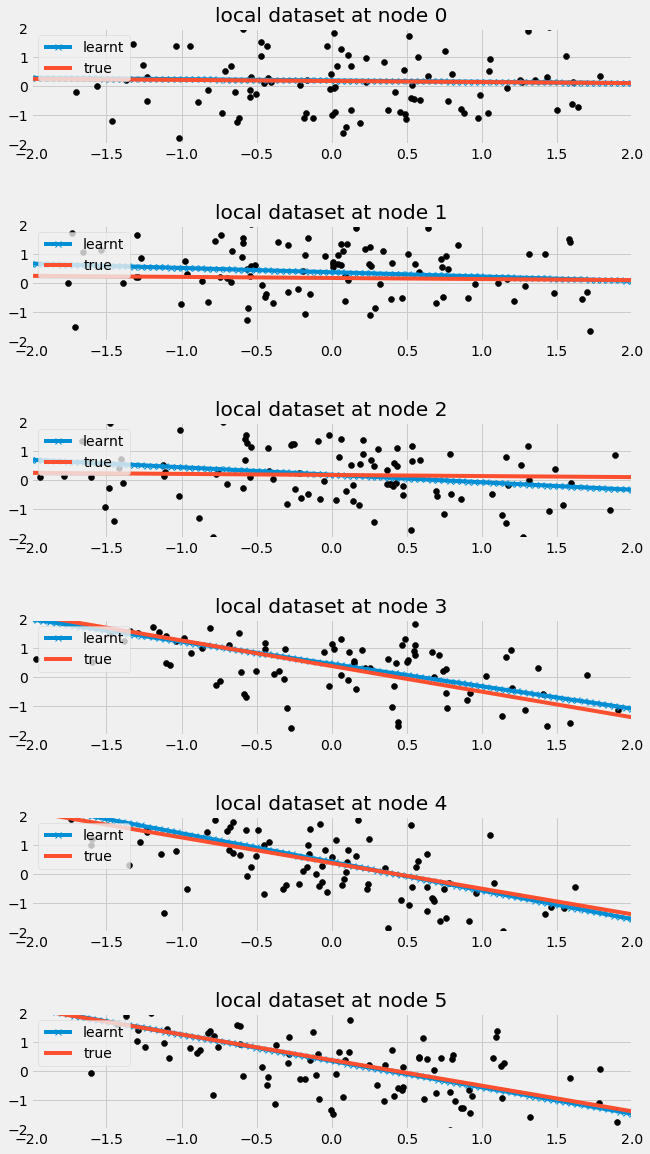

In [58]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(G.nodes),figsize=(10,17))
plt.style.use('fivethirtyeight')
    
X_grid = np.hstack((np.linspace(-2.0, 2.0, 100).reshape(-1,1),np.ones((100,1))))

for iter_node in G.nodes: 
    X = G.nodes[iter_node]["X"]
    y = G.nodes[iter_node]["y"]
    learnt_weights = G.nodes[iter_node]["weights"]
    txt="local dataset at node "+str(iter_node)
    axs[iter_node].set_ylim([-2, 2])
    axs[iter_node].set_xlim([-2, 2])
    axs[iter_node].title.set_text(txt)
    axs[iter_node].scatter(X[:,0], y, color='black')
    
    # illustrate the learnt weights by a straight line obtained by evaluating the 
    # corresponding linear predictor for a regular grid of feature values X_grid
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(learnt_weights),marker="x",label = "learnt")
    
    # illustrate the optimal predictor obtained from the ground truth weight vector
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(true_weights[:,G.nodes[iter_node]["block"]]), label ="true")
    axs[iter_node].legend(loc='upper left')

plt.tight_layout(pad=3.0)
plt.show()